# **MDD diagnosis based on EEG feature fusion and improved feature selection**
 Wan Chen, Yanping Cai*, Aihua Li, Yanzhao Su, Ke Jiang
 Rocket Force University of Engineering, Xi’an 710025, China

## **一、包导入**

In [10]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import mne
import matplotlib.pyplot as plt
import os
import utilities as ut
import mne_connectivity

In [11]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号
plt.rcParams['text.usetex'] = True
np.set_printoptions(threshold=np.inf)# 设置NumPy的打印选项，以打印整个数组

## **二、文件批量读取读取->数据预处理->频带划分->求各频带功能连接矩阵**

### (0) 电极重命名
### (1) 数据滤波: 50Hz陷波滤波,0.5-50Hz带通滤波    
    凹陷滤波，指的是在某个频率范围内的信号会被衰减过滤掉，而这个频率范围以外的信号会被保留下来。
    这个操作通常是用来去除50Hz市电的干扰。我国的50Hz，因此在收集到的信号中，会有一个非常强烈的50Hz频段的信号存在，这就可以用凹陷滤波来去掉。
### (2) 伪迹去除：使用独立成分分析（ICA）
    由于ICA对低频分离效果不好,这里对高通1Hz的数据进行ICA及相关成分剔除，再应用到高通0.1Hz的数据上
### (3)重参考:使用全脑平均参考
    首先要解释的是参考的定义。我们看到采集之后的数据是一个个的数值，但这个数值是什么意思呢，就是电极所在位置跟参考电极之间的电位差。
    一般在脑电记录的时候会采用的参考电极有鼻尖参考，cz或头顶中央参考，还有单侧乳突参考，乳突就是耳朵后面一小块突起的区域。我们所看到的每个通道的数值，其实就是指这个通道跟参考通道之间的电位差。
    在分析数据的时候，有时候我们会想要转换参考点的位置。因为不同位置的参考，会对数据造成一定的影响。比如记录时采用的是cz或头顶中央参考，那么自然地，距离cz点较近的电极点，记录到的电位差会非常小，而离得远的电极记录到的电位差就自然会大一点，这种大与小的差异，并不是由认知活动产生的，而是由记录方式产生的。又比如，单侧乳突参考，那脑袋左边的电极点跟右边的电极点，也会存在着记录方式不同产生的电位差不同。
    常用的一些参考位置有双侧乳突平均参考，指将两个乳突数据的平均值作为参考数据，或者是全脑平均参考，指的是将全脑所有数据的均值作为参考数据的方法，不过使用全脑平均参考的时候要注意，眼电数据不要纳入其中，因为眼电数据的波动起伏非常大，很容易对数据造成比较大的干扰。
### (4)数据分段：提取60秒后的100秒数据，分割成10秒的时间段
### (5)频带提取：Delta,Theta,Alpha,Beta,Gamma,Full

Extracting EDF parameters from f:\脑电\EEG论文\论文复现\data\H\H S1 EO.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 89855  =      0.000 ...   350.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter ord

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.3s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Averaging across epochs before plotting...


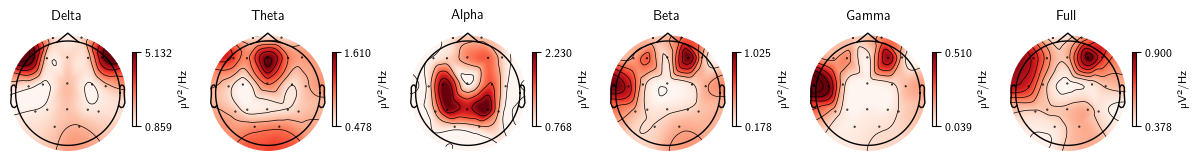

Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spect

C:\Users\Administrator\AppData\Roaming\Python\Python312\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


    assembling connectivity matrix
[Connectivity computation done]
Replacing existing metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 14.0Hz..30.0Hz (161 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral 

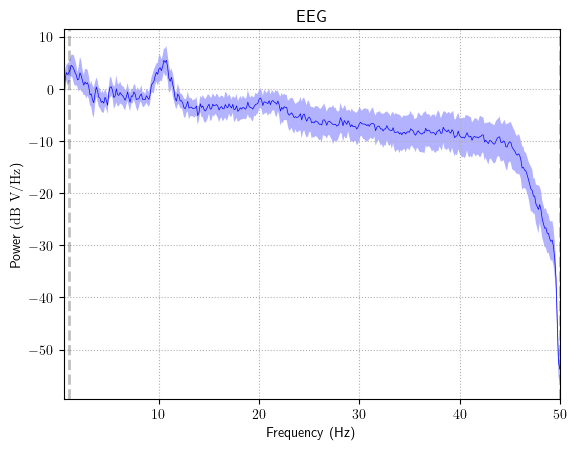

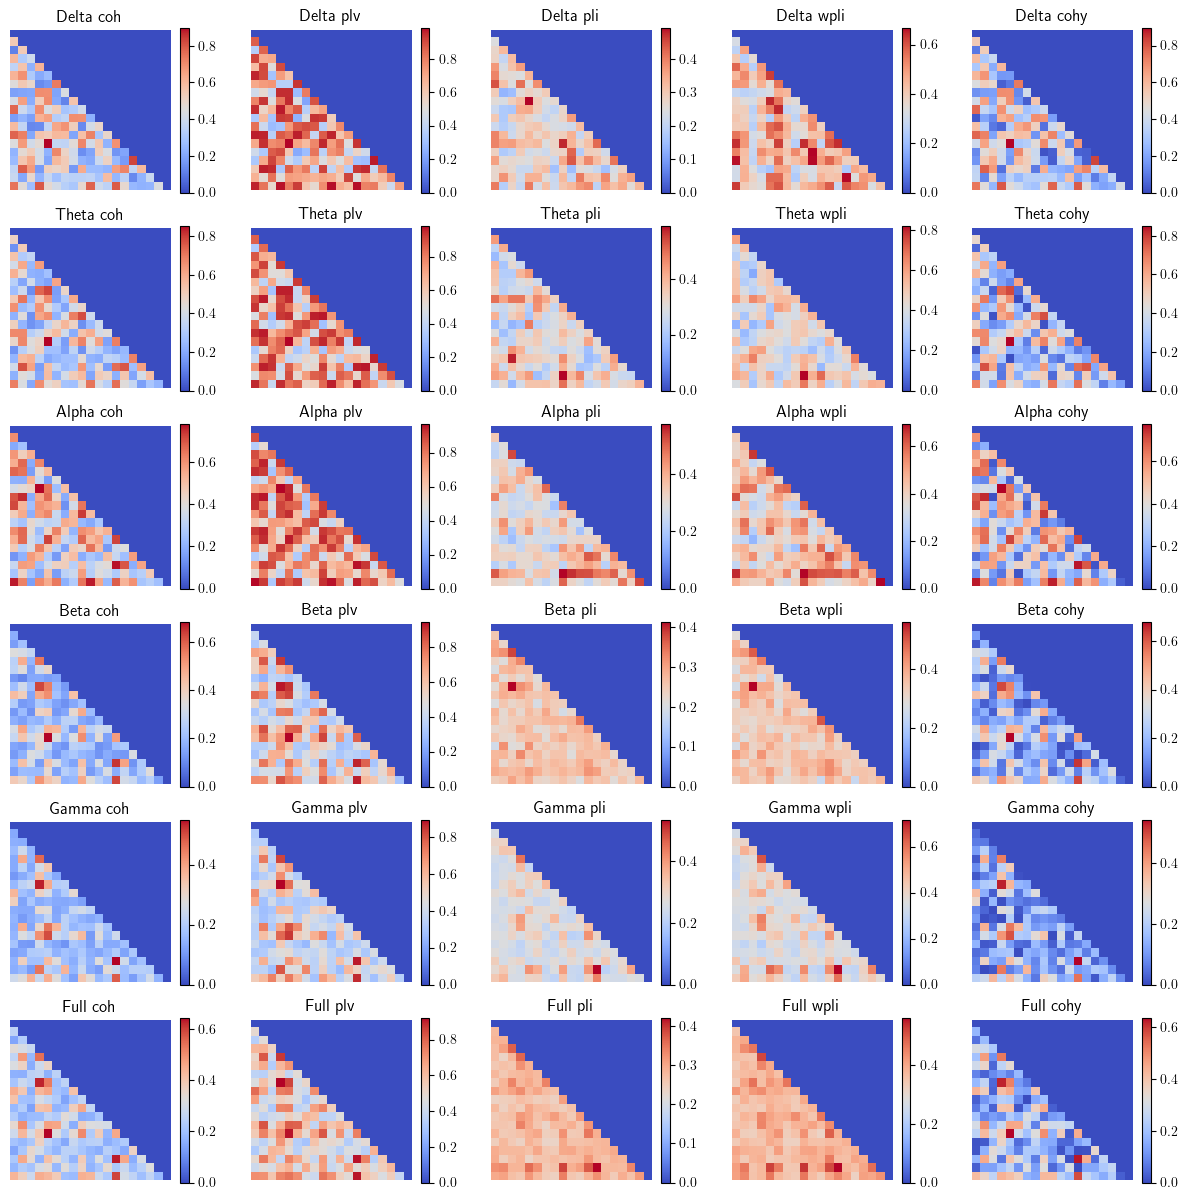

Extracting EDF parameters from f:\脑电\EEG论文\论文复现\data\H\H S10 EO.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter or

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.3s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectral

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 2.5s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectral

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.5s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 4 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 2.1s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 4 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 2.4s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 4 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 4 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 4 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.3s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectral

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Selecting by non-zero PCA components: 19 components
Fitting ICA took 2.8s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, P

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.8s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 4 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.3s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 5 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.4s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 5 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.5s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectral

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.2s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 5 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 31.2s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectr

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
Replacing existing metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 8.0Hz..14.0Hz (61 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectral density for epoch 1
    computing cross-spectral d

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 4 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 3 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectral

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 31.2s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectr

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
Replacing existing metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 8.0Hz..14.0Hz (61 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectral d

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.1s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 5 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 2.9s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.5s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 3 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.4s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 5 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 3 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectral

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.8s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.8s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.4s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 3 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.1s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.1s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectral

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.1s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectral

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectral

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.8s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 3 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.3s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectral

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 3 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.2s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 3 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 2.4s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 3 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.8s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.2s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 4 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 2.4s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.3s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.1s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectral

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.3s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.2s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectral

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.1s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectral

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.3s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectral

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.4s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectral

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 2560 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..9.996s for estimation (2560 points)
    frequencies: 0.5Hz..4.0Hz (36 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, PLI, WPLI, Coherency
    computing cross-spectra

In [12]:
raw_data_dir = './data/'

all_files = []
for _dir in os.listdir(raw_data_dir):
    sub_dir = os.path.join(raw_data_dir, _dir)
    if os.path.isdir(sub_dir):
        for file in os.listdir(sub_dir):
            edf_file_path = os.path.join(sub_dir, file)
            all_files = all_files + [edf_file_path]
display = 1

# num_eeg_data = 19 * 256 * 10 # 19通道，256HZ * 10s
# num_conns_data = 19 * (19-1) // 2 * len(ut.bands) * len(ut.conn_methods) # 下三角矩阵元素数量19*(19-1)/2, 频带数，特性数
# num_eeg_files = 58
# entire_fusion_features_matrix = np.zeros(shape=(num_eeg_data * num_conns_data * num_eeg_files), dtype=float)
for edf_file_path in all_files:
    raw = mne.io.read_raw_edf(edf_file_path, preload=True)

    ### (0) 电极重命名
    # valid channel names
    valid_channel_names = ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE']
    raw.pick(valid_channel_names)
    # 创建电极名称映射字典
    channel_mapping = {
        'EEG Fp1-LE':'Fp1', 'EEG F3-LE':'F3',   'EEG C3-LE':'C3',   'EEG P3-LE':'P3',   'EEG O1-LE':'O1',
        'EEG F7-LE':'F7',   'EEG T3-LE':'T3',   'EEG T5-LE':'T5',   'EEG Fz-LE':'Fz',   'EEG Fp2-LE':'Fp2',
        'EEG F4-LE':'F4',   'EEG C4-LE':'C4',   'EEG P4-LE':'P4',   'EEG O2-LE':'O2',   'EEG F8-LE':'F8',
        'EEG T4-LE':'T4',   'EEG T6-LE':'T6',   'EEG Cz-LE':'Cz',   'EEG Pz-LE':'Pz',
        # 'EEG A2-A1': 'A2','EEG 23A-23R':'23A','EEG 24A-24R': '24A',
    }
    raw.rename_channels(channel_mapping)# 电极重命名为标准名称
    montage = mne.channels.make_standard_montage('standard_1020')# 创建标准的10-20系统电极布局
    raw.set_montage(montage)# 应用电极布局到数据
    # raw.plot_sensors(ch_type='eeg', show_names=True)

    ### (1) 数据滤波
    raw.notch_filter(freqs=50) # 50Hz陷波滤波    
    raw.filter(l_freq=0.5, h_freq=50, method='iir') # 0.5-50Hz带通滤波

    # (2) 伪迹去除：使用独立成分分析（ICA）
    ica = mne.preprocessing.ICA(max_iter='auto', random_state=97)  
    raw_for_ica = raw.copy().filter(l_freq=1, h_freq=None)
    ica.fit(raw_for_ica)
    file_name_witout_extension = os.path.splitext(os.path.basename(edf_file_path))[0]
    ica.exclude = ut.excludes[file_name_witout_extension] # 选择伪迹成分进行去除
    raw_clean = ica.apply(raw_for_ica.copy())

    # (3) 重参考：使用全脑平均参考
    raw_clean.set_eeg_reference('average', projection=False)
    # (4) 数据分割
    raw_clean_temp = raw_clean.copy()
    raw_clean_segment = raw_clean_temp.crop(tmin=60, tmax=160) # 提取60秒后的100秒数据    
    epochs = mne.make_fixed_length_epochs(raw_clean_segment, duration=10, overlap=0) # 将数据分割成10秒的时间段
    # (5) 频带提取
    epochs_spectrum = epochs.compute_psd(fmin=0.5,fmax=50, method='welch')
    if display:
        epochs_spectrum.plot_topomap(bands=ut.bands) # ,vlim='joint'
        %matplotlib inline
        plt.figure()
        ax = plt.axes()
        epochs_spectrum.plot(average=True, color='blue', axes=ax)
        # psds, freqs = epochs_spectrum.get_data(return_freqs=True)
        # # 提取每个频带的功率
        # band_powers = {}
        # for band_name, (fmin, fmax) in bands.items():
        #     band_powers[band_name] = np.mean(psds[:, (freqs >= fmin) & (freqs <= fmax)], axis=1)

        # # 打印每个频带的功率
        # for band_name, power in band_powers.items():
        #     print(f"Mean power in {band_name} band: {np.mean(power)}")
    
    # (6) 计算各频带功能连接矩阵
    # epochs_data = epochs.get_data()
    # for epoch_idx in range(epochs_data.shape[0]):
    bands_conns = {}
    for band_name, (fmin, fmax) in ut.bands.items():
        conns = mne_connectivity.spectral_connectivity_epochs(epochs, method=ut.conn_methods, mode='multitaper', sfreq=epochs.info['sfreq'], fmin=fmin, fmax=fmax, faverage=True, indices=None)
        conns_dict = {}
        for i in range(len(ut.conn_methods)):
            conn_matrix = conns[i].get_data().reshape(19,19)
            conn_matrix = np.sqrt(np.real(conn_matrix) **2, np.imag(conn_matrix) ** 2)
            conns_dict[ut.conn_methods[i]] = conn_matrix
        bands_conns[band_name] = conns_dict
    if  display:
        rows = len(ut.bands)
        cols = len(ut.conn_methods)
        plt.figure(figsize=(15, 15))
        plt_idx = 1
        for band_name, _coons in bands_conns.items():
            for conn_method, conn_matrix in _coons.items():
                plt.subplot(rows, cols, plt_idx)
                plt_idx += 1
                # 可视化连接矩阵
                plt.imshow(conn_matrix, cmap='coolwarm', interpolation='nearest')
                plt.colorbar()
                plt.xticks(np.arange(0, 19, 1))  # 设置x轴的刻度从0到10，步长为1
                plt.yticks(np.arange(0, 19, 1))  # 设置y轴的刻度从-1到1，步长为1
                plt.title(f'{band_name} {conn_method}')
                plt.axis('off')  # 关闭坐标轴
        plt.show()
        display=0
    # (7) 取功能连接矩阵的下三角形 19*(19-1)/2=171个值为单个频带单个功能的特征向量
    conn_eigenvectors_dict={} #单个功能链接矩阵的维度为171*6=1026  key:conn_method,value:ndarray(shape=(1026))
    for conn_method in ut.conn_methods:
        conn_eigenvector = None
        for band_name in bands_conns:
            conn_matrix = bands_conns[band_name][conn_method]
            row_idx, col_idx = np.tril_indices(19, k=-1)  # k=-1 表示不包含对角线
            conn_eigenvector = conn_matrix[row_idx, col_idx] if conn_eigenvector is None else np.hstack((conn_eigenvector, conn_matrix[row_idx, col_idx]))
            # print(conn_eigenvector.shape)
        conn_eigenvectors_dict[conn_method] = conn_eigenvector
    conn_eigenvectors = None
    for band_name, curr_eigenvectors in conn_eigenvectors_dict.items():
        conn_eigenvectors = conn_eigenvectors_dict[band_name] if conn_eigenvectors is None else np.hstack((conn_eigenvectors, conn_eigenvectors_dict[band_name]))
    output_filename = "H_conn_eigenvectors.txt" if file_name_witout_extension.startswith("H") else "MDD_conn_eigenvectors.txt"
    with open(output_filename, "a") as f:
        print(conn_eigenvectors, file = f)
    # entire_fusion_features_matrix[i * num_eeg_data:i * num_eeg_data + num_conns_data] = conn_eigenvectors

In [13]:
# epochs_data = epochs.get_data()
# print("epochs_data.shape = (10段, 19通道, 256HZ) = ", epochs_data.shape)

## 三、网络构建

### 3.1 包导入

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import helper as hp
import torchvision
from torchvision import transforms,datasets
from torch.utils.data import DataLoader, TensorDataset
import utilities as ut
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import time

### 3.2 构建CNN类
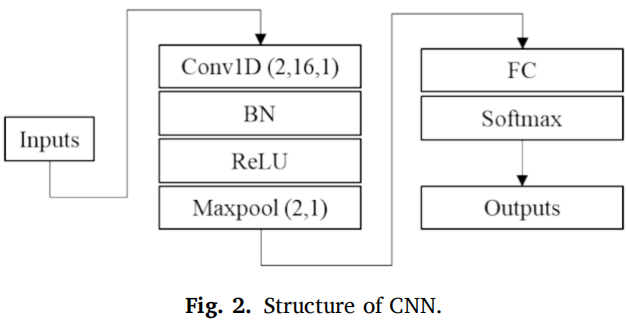

In [2]:
class Simple1DCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(Simple1DCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=16, kernel_size=2, stride=1)
        self.bn1 = nn.BatchNorm1d(16)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=1)
        self.fc = nn.Linear(16, num_classes)
    
    def forward(self, x):
        # Convolutional block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        # Flatten and fully connected layer
        x = torch.mean(x, dim=2)  # Global average pooling (optional for flattening)
        x = self.fc(x)
        x = F.softmax(x, dim=1)
        return x

### 3.3 数据读取

In [11]:
train_data, train_label, test_data, test_label = hp.Split_Train_Test() # 划分数据集

batch_size = 8
# 创建数据加载器
traindataset = TensorDataset(train_data, train_label)
traindataloader = DataLoader(traindataset, batch_size=batch_size, shuffle=True)
testdataset = TensorDataset(test_data, test_label)
testdataloader = DataLoader(testdataset, batch_size=batch_size, shuffle=False)

In [12]:
num_eeg_data = 19 * 256 * 10 # 19通道，256HZ * 10s
num_conns_data = 19 * (19-1) // 2 * len(ut.bands) * len(ut.conn_methods) # 下三角矩阵元素数量19*(19-1)/2, 频带数，特性数
input_channels = 1
num_classes = 2
model = Simple1DCNN(input_channels=input_channels, num_classes=num_classes)
model = model.to(device)
epochs = 50
lr=0.001
criterion = nn.CrossEntropyLoss()  # 交叉熵损失
optimizer = optim.Adam(model.parameters(), lr=lr)


In [13]:
#存储每一个epoch的loss与acc的变化，便于后面可视化  
train_loss_list = []  
train_acc_list = []  
test_loss_list = []  
test_acc_list = []  
time_list = []  
timestart = time.time()  
#进行训练  
for epoch in range(epochs):  
    #每一个epoch的开始时间  
    epochstart = time.time()  
      
    #在训练集上训练  
    train_loss, train_acc = hp.train_epoch(model,data_loader=traindataloader, optimizer=optimizer, criterion=criterion, device=device)  
    #在测试集上验证  
    test_loss, test_acc = hp.test_epoch(model,data_loader=testdataloader, criterion=criterion, device=device)  
      
    #每一个epoch的结束时间  
    elapsed = (time.time() - epochstart)  
    #保存各个指际  
    train_loss_list.append(train_loss)  
    train_acc_list.append(train_acc )  
    test_loss_list.append(test_loss)  
    test_acc_list.append(test_acc)  
    time_list.append(elapsed)  
    print('epoch %s, train_loss %.6f,test_loss %.6f,train_acc %.6f,test_acc %.6f,Time used %.6fs'%(str(epoch+1).zfill(2), train_loss,test_loss,train_acc,test_acc,elapsed))  
#计算总时间  
timesum = (time.time() - timestart)  
print('The total time is',timesum,'s')

epoch 01, train_loss 0.708387,test_loss 0.708159,train_acc 0.434783,test_acc 0.333333,Time used 0.066287s
epoch 02, train_loss 0.702656,test_loss 0.706841,train_acc 0.434783,test_acc 0.333333,Time used 0.062178s
epoch 03, train_loss 0.699077,test_loss 0.705606,train_acc 0.456522,test_acc 0.333333,Time used 0.071999s
epoch 04, train_loss 0.695778,test_loss 0.704456,train_acc 0.456522,test_acc 0.333333,Time used 0.079131s
epoch 05, train_loss 0.693354,test_loss 0.704778,train_acc 0.456522,test_acc 0.333333,Time used 0.032006s
epoch 06, train_loss 0.693066,test_loss 0.707013,train_acc 0.521739,test_acc 0.333333,Time used 0.104332s
epoch 07, train_loss 0.688629,test_loss 0.708768,train_acc 0.565217,test_acc 0.333333,Time used 0.017514s
epoch 08, train_loss 0.688123,test_loss 0.712312,train_acc 0.565217,test_acc 0.333333,Time used 0.017999s
epoch 09, train_loss 0.686034,test_loss 0.714262,train_acc 0.565217,test_acc 0.333333,Time used 0.018998s
epoch 10, train_loss 0.687950,test_loss 0.7200

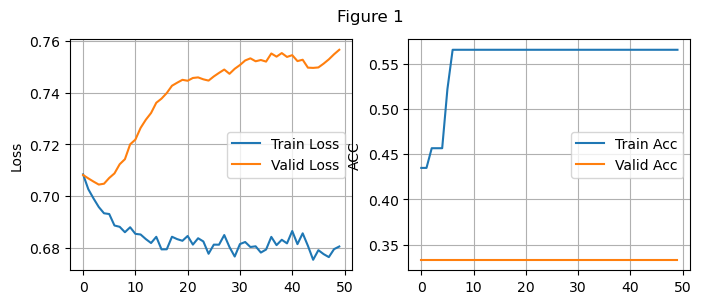

In [14]:
hp.show_figure(fignum=1,loss=[train_loss_list,test_loss_list],acc=[train_acc_list,test_acc_list])